# Importações e Definições Gerais

In [1]:
from datetime import datetime

# Numero de classes a ser considerada
n=50
ref=datetime.now().strftime("%Y%m%d")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from numpy.random import seed
import pickle
from tqdm import tqdm

import pytz
from collections import Counter
import math

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pasta = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Resultados/'
modelo = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Modelos/'
execucoes = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Execuções/'

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Modelos_Implementações')

In [6]:
class logfile():

  def __init__(self, diretorio):
    self.diretorio=diretorio

  def start(self, tag, use_dateref=True):
    if use_dateref:
      tag = tag + '_' + datetime.now(pytz.timezone('America/Bahia')).strftime("%Y%m%d")
    self.save_file = open(self.diretorio +  tag + '.txt', 'w')
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Execução em:', data_atual, file=self.save_file)
    
  def end(self):
    data_atual = datetime.now(pytz.timezone('America/Bahia')).strftime("%d/%m/%Y %H:%M:%S")
    print('Fim de Execução em:', data_atual, file=self.save_file)
    self.save_file.close()

# Dataset

In [7]:
def get_labels():
  labels= pd.read_csv(r'/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/identity_CelebA.txt', header=None)

  labels.rename(columns={0:'id'},inplace=True)

  labels['class'] = labels['id'].apply(lambda x:x.split()[1])
  labels['class'] = labels['class'].astype(int)
  labels['image'] = labels['id'].apply(lambda x:x.split()[0])

  labels.set_index('image', inplace=True)

  print('Total de {} imagens com {} classes'.format(labels.shape[0], len(labels['class'].unique())))

  return labels

labels = get_labels()

Total de 202599 imagens com 10177 classes


In [8]:
def get_celeb_attributes():
  celebs_attributes = pd.read_csv(r'/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/list_attr_celeba.csv')
  celebs_attributes.set_index('image_id', inplace=True)
  m_sample =  celebs_attributes.shape[0]
  print('Total de {} imagens com {} caracteristicas'.format(m_sample, celebs_attributes.shape[1]))
  celebs_attributes=celebs_attributes.apply(lambda x:x>0)
  celebs_attributes =celebs_attributes.merge(labels, left_index=True, right_index=True, how ='inner')
  assert celebs_attributes.shape[0]==m_sample
  return celebs_attributes

celebs_attributes = get_celeb_attributes()

Total de 202599 imagens com 40 caracteristicas


In [9]:
import zipfile
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize

def generate_image_db(keep_images):
  imagens_path = '/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/CelebA/img_align_celeba.zip'
  imgzip = zipfile.ZipFile(imagens_path)
  inflist = imgzip.infolist()
  all_images = {}

  for f in tqdm(inflist):
    file_name = f.filename.split('/')[1]
    if file_name in keep_images:
      if '.jpg' in file_name:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        img_resize = resize(np.array(img), (128, 128))
        all_images[file_name] = img_resize

  return all_images

In [10]:
def viola_jones(original_image, show=False):

  face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") #Note the change

  img = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
  gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray_img, scaleFactor=1.05,minNeighbors=5)

  for x, y, w, h in faces:
    cropped_img = gray_img[y:y+h, x:x+w]
    break
    
  if show:
    img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
    resized=cv2.resize(img,(int(img.shape[1]/3), int(img.shape[0]/3))) 

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

  return cropped_img


def generate_image_VIOLAJONES_db(keep_images, save=False, tag=None):

  imgzip = zipfile.ZipFile('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/CelebA/img_align_celeba.zip')
  inflist = imgzip.infolist()
  all_images = {}

  # Testando com imagens da classe 3

  for f in tqdm(inflist):
    file_name = f.filename.split('/')[1]
    if file_name in keep_images:
        ifile = imgzip.open(f)
        img = Image.open(ifile)
        
        try:
          cropped = viola_jones(img)
          all_images[file_name] = (cropped, 1)
        except:
          all_images[file_name] = (img, 0)
  
  if save:
    with open('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/dataset_VJ_'+ tag+'.obj', 'wb') as fp:
      pickle.dump(all_images, fp)

  return all_images

In [11]:
blurry_images = celebs_attributes[(celebs_attributes['Blurry'])]

print('numero de amostras c/ caracteristicas:', blurry_images.shape[0] )
print('percentual da base:', blurry_images.shape[0]/labels.shape[0] )

blurry_images = blurry_images.index

numero de amostras c/ caracteristicas: 10312
percentual da base: 0.05089857304330229


In [12]:
print('Quantidade de classes distintas no dataset inteiro:', len(labels['class'].unique()))

Quantidade de classes distintas no dataset inteiro: 10177


In [13]:
def filter_by_class(n):
  topn_classes = labels['class'].value_counts().head(n).index
  topn_classes_imgs_base = labels[labels['class'].isin(topn_classes)]
  topn_classes_imgs = topn_classes_imgs_base.index
  topn_classes_imgs = [img for img in labels.index if img in topn_classes_imgs and (img not in blurry_images)]

  print('São imagens {} de {} pessoas o que corresponde a {}% da base'.format(
      len(topn_classes_imgs), 
      len(topn_classes_imgs_base['class'].unique()),
      round(100*len(topn_classes_imgs)/labels.shape[0],2)))

  return topn_classes_imgs

viola_keep = filter_by_class(n)

São imagens 1465 de 50 pessoas o que corresponde a 0.72% da base


In [14]:
# Cria df com imagens do viola
viola_output = generate_image_VIOLAJONES_db(viola_keep, save=True, tag=ref)
dataset = pd.DataFrame(viola_output).T
dataset.columns = ['img', 'viola_jones_success']

# grau de assertividade do viola jones
print(dataset['viola_jones_success'].value_counts())

dataset = dataset[dataset['viola_jones_success']==1]
dataset = dataset.merge(labels, left_index=True, right_index=True,how='left')

100%|██████████| 202600/202600 [01:05<00:00, 3083.06it/s]


1    1443
0      22
Name: viola_jones_success, dtype: int64


In [15]:
dataset_work = dataset.copy()
import gc
del dataset
gc.collect()

0

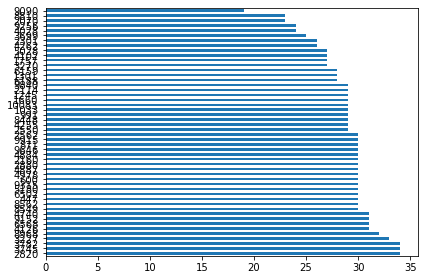

In [16]:
dataset_work['class'].value_counts().plot(kind='barh')
plt.tight_layout()

In [17]:
classes_n= dataset_work['class'].unique()
n_classes = len(classes_n)
indexes = np.arange(0,len(classes_n))
conversor_classes = {classes_n[i]: indexes[i] for i in range(len(classes_n))}

In [18]:
dataset_work['class'] = dataset_work['class'].map(conversor_classes)

In [19]:
from skimage.transform import resize

dataset_work['img_resized'] = dataset_work['img'].progress_apply(lambda x: resize(x, (50, 50)))

100%|██████████| 1443/1443 [00:01<00:00, 871.85it/s]


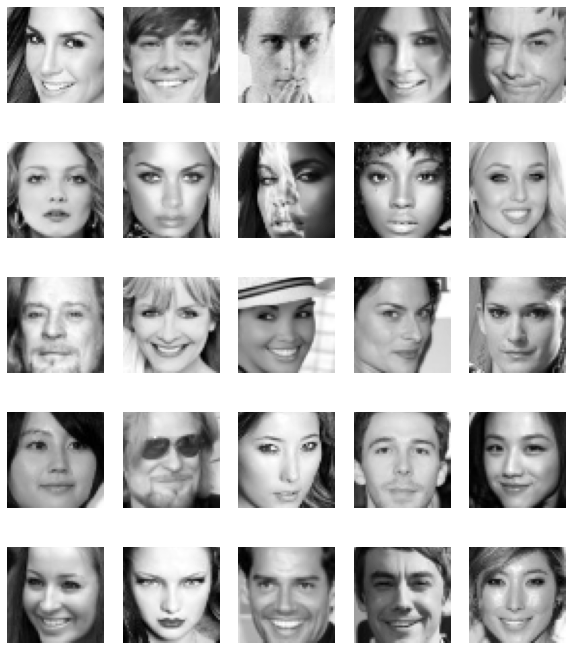

In [20]:
# faces que foram reconhecidas pelo viola jones
fig, axes = plt.subplots(5,5, figsize=(10,12))

for (i,row), ax in zip(dataset_work.head(25).iterrows(), axes.ravel()): 
  ax.axis('off')
  ax.imshow(row['img_resized'], cmap=plt.cm.gray)

#HOG

100%|██████████| 5/5 [00:00<00:00, 43.75it/s]


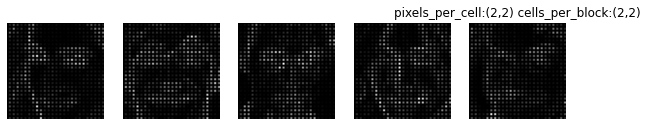

100%|██████████| 5/5 [00:00<00:00, 124.97it/s]


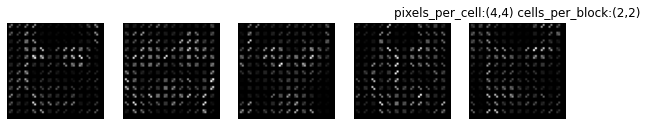

100%|██████████| 5/5 [00:00<00:00, 358.08it/s]


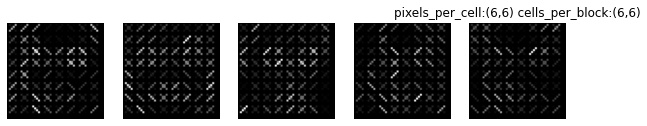

100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


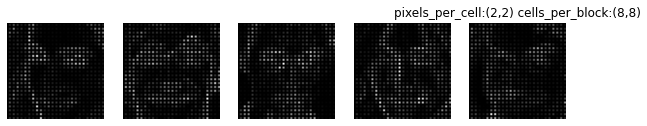

In [21]:
def hog_visualize(df, ppc,cpb, n_img=5):

  aux = df.head(n_img).copy()

  aux['img_hog'] = aux['img_resized'].progress_apply(lambda x: hog(x, orientations=2, pixels_per_cell=(ppc,ppc),cells_per_block=(cpb, cpb), visualize=True)[1])

  fig, axes = plt.subplots(1,5, figsize=(10,6))

  for (i,row), ax in zip(aux[['img_hog']].head(5).iterrows(), axes.ravel()): 
    ax.axis('off')
    ax.imshow(row['img_hog'], cmap=plt.cm.gray)
  plt.title('pixels_per_cell:({},{}) cells_per_block:({},{})'.format(ppc,ppc, cpb, cpb))
  plt.show()

hog_visualize(dataset_work, 2,2)
hog_visualize(dataset_work, 4,2)
hog_visualize(dataset_work, 6,6)
hog_visualize(dataset_work, 2,8)

In [22]:
dataset_work['img_hog'] = dataset_work['img_resized'].progress_apply(
    lambda x: hog(x, orientations=2, pixels_per_cell=(2,2),cells_per_block=(2, 2), visualize=False))

X_hog = dataset_work['img_hog'].apply(pd.Series)
y = dataset_work['class']

tag = 'hog_' + str(n) + '_classes'

with open('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/X_y_' + tag +'.obj', 'wb') as fp:
  pickle.dump((X_hog,y), fp)

100%|██████████| 1443/1443 [00:17<00:00, 80.51it/s]


# LBP

100%|██████████| 5/5 [00:00<00:00, 1803.23it/s]


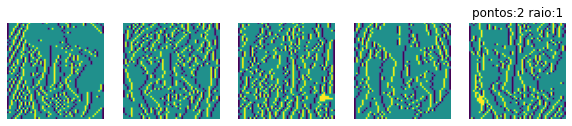

100%|██████████| 5/5 [00:00<00:00, 1286.60it/s]


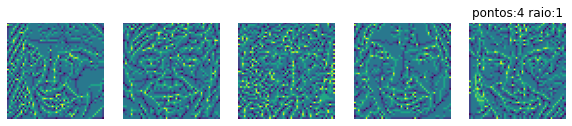

100%|██████████| 5/5 [00:00<00:00, 2097.99it/s]


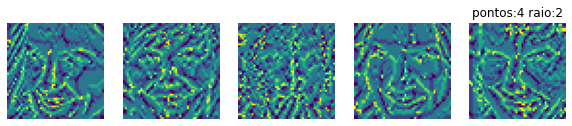

100%|██████████| 5/5 [00:00<00:00, 1304.04it/s]


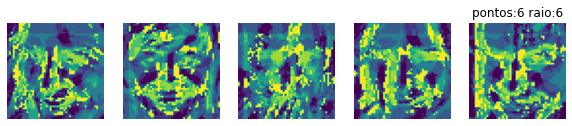

100%|██████████| 5/5 [00:00<00:00, 894.54it/s]


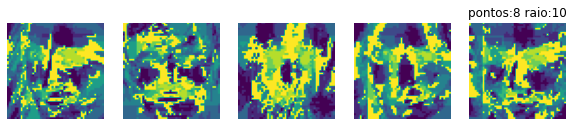

In [23]:
def lbp_visualize(df, points=4,radius=2, n_img=5):

  aux = df.head(n_img).copy()

  aux['img_lbp'] = aux['img_resized'].progress_apply(lambda x: 
                                                     local_binary_pattern(x,  P  = points, R = radius, method  = 'uniform'))

  fig, axes = plt.subplots(1,5, figsize=(10,6))

  for (i,row), ax in zip(aux[['img_lbp']].head(5).iterrows(), axes.ravel()): 
    ax.axis('off')
    ax.imshow(row['img_lbp'])
  plt.title('pontos:{} raio:{}'.format(points,radius))
  plt.show()

lbp_visualize(dataset_work, 2,1)
lbp_visualize(dataset_work, 4,1) 
lbp_visualize(dataset_work, 4,2) # Escolhido<<<
lbp_visualize(dataset_work, 6,6)
lbp_visualize(dataset_work, 8,10)

In [24]:
dataset_work['img_lbp'] = dataset_work['img_resized'].progress_apply(
    lambda x: local_binary_pattern(x,  P  = 4, R = 2, method  = 'uniform').flatten())

X_lbp = dataset_work['img_lbp'].apply(pd.Series)
y = dataset_work['class']

tag = 'lbp_' + str(n) + '_classes'

with open('/content/drive/MyDrive/Projeto ML/2022/Aprendizado de Maquinas/Projeto/Pipeline/Data/X_y_' + tag +'.obj', 'wb') as fp:
  pickle.dump((X_lbp,y), fp)

100%|██████████| 1443/1443 [00:00<00:00, 4811.24it/s]
